# XBeach data forcing

Demo notebook with usage examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shutil

import warnings
warnings.filterwarnings("ignore")

In [3]:
def generate_output_directory(path="forcing-demo"):
    """Generate the output dir for the examples, removing it if it already exists."""
    outdir = Path(path)
    if outdir.exists():
        shutil.rmtree(outdir)
    outdir.mkdir()
    return outdir

In [4]:
datadir = Path("../../../rompy-xbeach/tests/data")

## Overview

XBeach forcing objects provide an interface to generate model forcing from existing data.

## Interfaces

XBeach forcing interfaces are intantiated with a `Source` instance plus some parameters
that are specific to each input forcing. They all have a `get()` method which
takes as inputs the workspace `destdir` directory, the model `grid`, and the model `time`.
The source data are sliced over the model times and at the location of either the
centre of the grid or the offshore boundary middle point. The sliced data are used to
create XBeach forcing files and instructions. The method returns a dictionary with the
key-value pair to write in the XBeach params file.

Let's start off by defining some input source, time and grid objects to use with
the different boundary objects. The `spectra` and `param` prefixes indicate objects to
use with boundary objects based on spectra and integrated parameters data, respectively

In [5]:
from rompy.core.time import TimeRange
from rompy_xbeach.grid import RegularGrid
from rompy.core.source import SourceTimeseriesCSV
from rompy_xbeach.source import SourceCRSFile
from rompy_xbeach.forcing import WindGrid, WindStation, WindPoint, WindVector, WindScalar

In [6]:
# Data source
source_wind_grid = SourceCRSFile(
    uri="../../../rompy-xbeach/tests/data/era5-20230101.nc",
    crs=4326,
)
source_wind_station = SourceCRSFile(
    uri="../../../rompy-xbeach/tests/data/smc-params-20230101.nc",
    crs=4326,
)
source_wind_timeseries = SourceTimeseriesCSV(
    filename="../../../rompy-xbeach/tests/data/wind.csv",
    tcol="time",
)

# Model times
times = TimeRange(start="2023-01-01T00", end="2023-01-01T12", interval="1h")

# Model grid
grid = RegularGrid(
    ori=dict(x=115.594239, y=-32.641104, crs="epsg:4326"),
    alfa=347.0,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

## Wind forcing

Wind forcing interfaces in rompy-xbeach generate wind data from existing data sources
at a single location within the grid. Two location options are available: the centre
or the middle point of the offshore boundary.

Wind data can be generated from gridded and station type input data.

### WindStation

XBeach wind forcing from stations type data sources.

In [7]:
# Create the output directory
destdir = generate_output_directory()

# Wind data can be prescribed from vector or scalar fields. The different type
# of fields are defined by the `WindVector` and `WindScalar` objects. We are going to
# work with a source data that has wind vector variables and so we are going to use
# the `WindVector` object.
wind_vars = WindVector(u="uwnd", v="vwnd")

# Instantiate a wind data object using the stations source, make sure the station
# coordinate 's' is correctly specified
wind = WindStation(
    source=source_wind_station,
    coords=dict(s="seapoint"),
    wind_vars=wind_vars,
)

# Generate the XBeach windfile and return the params instruction
namelist = wind.get(destdir=destdir, grid=grid, time=times)
namelist

{'windfile': 'wind-20230101T000000-20230101T120000.txt'}

In [8]:
windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       7.15     186.92
   3600.00       7.49     192.82
   7200.00       7.96     198.03
  10800.00       8.24     203.33
  14400.00       8.91     208.57
  18000.00       9.69     210.79
  21600.00      10.09     210.59
  25200.00      10.29     210.61
  28800.00      10.20     209.83
  32400.00      10.26     209.25
  36000.00      10.74     209.04
  39600.00      11.03     204.15
  43200.00      10.76     199.61



By default the source data are generated at the centre of the model grid but we can choose
to define it at the offshore grid boundary instead

In [9]:
wind = WindStation(
    source=source_wind_station,
    coords=dict(s="seapoint"),
    wind_vars=wind_vars,
    sel_method="idw",
    sel_method_kwargs=dict(tolerance=0.2),
    location="offshore",
)

namelist = wind.get(destdir=destdir, grid=grid, time=times)

windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       7.29     186.73
   3600.00       7.62     192.53
   7200.00       8.08     197.69
  10800.00       8.35     202.92
  14400.00       9.01     208.16
  18000.00       9.79     210.39
  21600.00      10.20     210.32
  25200.00      10.38     210.36
  28800.00      10.30     209.63
  32400.00      10.36     209.09
  36000.00      10.85     208.87
  39600.00      11.16     204.00
  43200.00      10.91     199.48



An Inverse Distance Weighting (IDW) algorithm is used to interpolate the source data
by default, but a nearest neighbour selection is also supported.

The station data selection use selection functions defined in wavespectra:
[sel_nearest](https://github.com/wavespectra/wavespectra/blob/master/wavespectra/core/select.py#L150) and [sel_idw](https://github.com/wavespectra/wavespectra/blob/master/wavespectra/core/select.py#L234)

In [10]:
wind = WindStation(
    source=source_wind_station,
    coords=dict(s="seapoint"),
    wind_vars=wind_vars,
    sel_method="nearest",
    sel_method_kwargs=dict(tolerance=0.2),
)

namelist = wind.get(destdir=destdir, grid=grid, time=times)

windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       6.56     187.88
   3600.00       6.91     194.24
   7200.00       7.43     199.65
  10800.00       7.74     205.24
  14400.00       8.47     210.50
  18000.00       9.26     212.66
  21600.00       9.66     211.88
  25200.00       9.88     211.76
  28800.00       9.78     210.76
  32400.00       9.81     209.96
  36000.00      10.26     209.81
  39600.00      10.47     204.85
  43200.00      10.12     200.22



Let's plot the original source data and the selected data

In [11]:
# Generated wind data
df = pd.read_csv(windfile, header=None, sep="\s+", names=["tsec", "wspd", "wdir"])
df.index = [times.start + timedelta(seconds=s) for s in df.tsec]
display(df)

# Source dataset
dset = source_wind_station.open().sel(time=slice(times.start, times.end))
display(dset[["uwnd", "vwnd", "longitude", "latitude"]])

,tsec,wspd,wdir
2023-01-01 00:00:00,0.0,6.56,187.88
2023-01-01 01:00:00,3600.0,6.91,194.24
2023-01-01 02:00:00,7200.0,7.43,199.65
2023-01-01 03:00:00,10800.0,7.74,205.24
2023-01-01 04:00:00,14400.0,8.47,210.50
2023-01-01 05:00:00,18000.0,9.26,212.66
2023-01-01 06:00:00,21600.0,9.66,211.88
2023-01-01 07:00:00,25200.0,9.88,211.76
2023-01-01 08:00:00,28800.0,9.78,210.76
2023-01-01 09:00:00,32400.0,9.81,209.96


<xarray.Dataset> Size: 10kB
Dimensions:      (time: 13, seapoint: 91)
Coordinates:
  * time         (time) datetime64[ns] 104B 2023-01-01 ... 2023-01-01T12:00:00
    spatial_ref  int64 8B 0
Dimensions without coordinates: seapoint
Data variables:
    uwnd         (time, seapoint) float32 5kB ...
    vwnd         (time, seapoint) float32 5kB ...
    longitude    (seapoint) float32 364B ...
    latitude     (seapoint) float32 364B ...
Attributes: (12/20)
    WAVEWATCH_III_version_number:  6.07
    WAVEWATCH_III_switches:        O0 O1 IS0 IC0 SMC RWND REF0 LN1 FLX4 ST6 M...
    first_lat:                     -74.96875
    first_lon:                     -179.96875
    base_lat_size:                 0.0625
    base_lon_size:                 0.0625
    ...                            ...
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2001-01-01 00:00:00
    stop_date:                     2001-02-01 00:00:00
    history:                       Wed Nov 13 16:42:53 2024: ncks -d time,0,2...
    NCO:                           netCDF Operators version 5.0.6 (Homepage =...

Plot the source and generated data

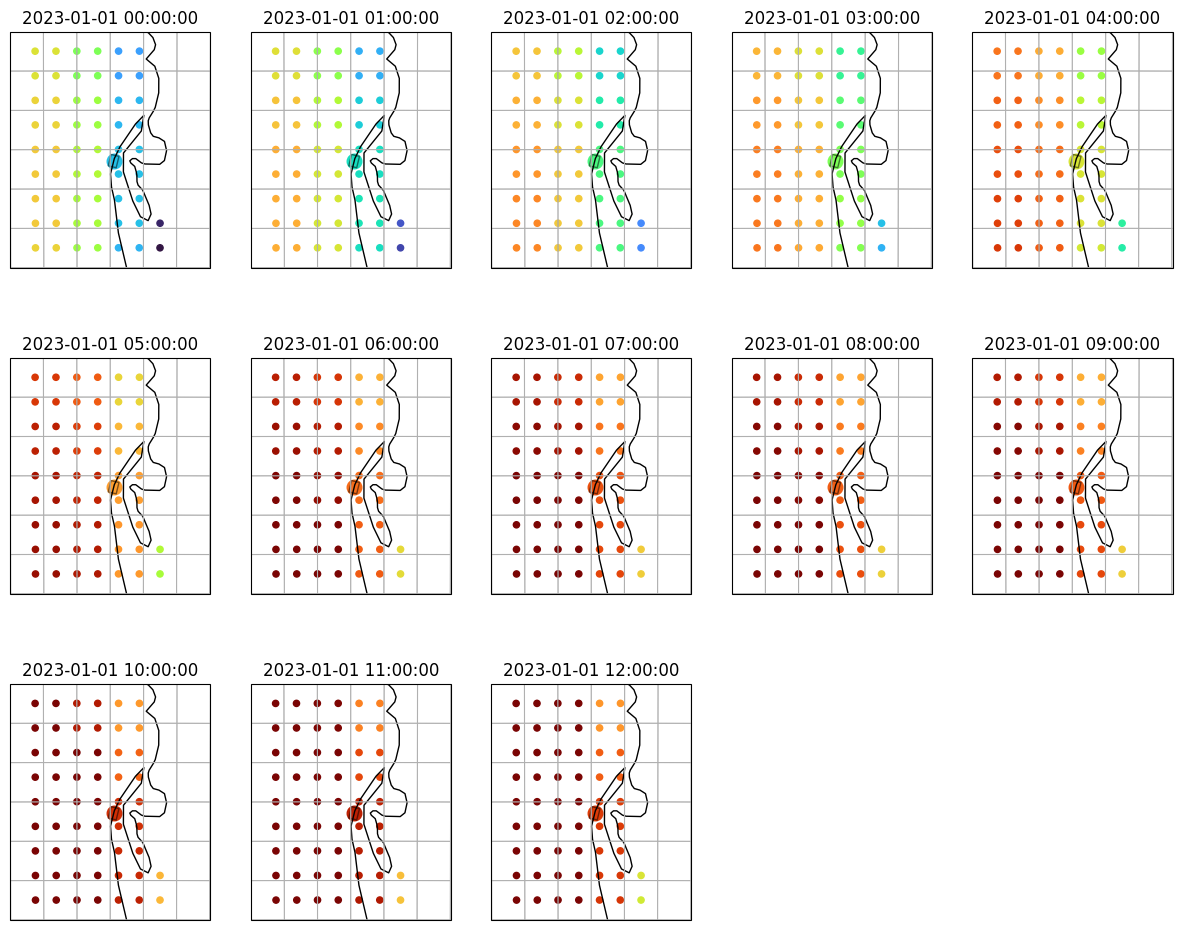

In [12]:
vmin = 5
vmax = 11
cmap = "turbo"

wspd = (dset.uwnd ** 2 + dset.vwnd ** 2) ** 0.5

fig, axs = plt.subplots(3, 5, figsize=(15, 12), subplot_kw=dict(projection=grid.projection))

for i, ax in enumerate(axs.flat):
    if i > df.shape[0] - 1:
        ax.axis("off")
        continue

    ax.coastlines()

    # Plot the source data
    source_data = wspd.isel(time=i)
    ax.scatter(
        dset.longitude,
        dset.latitude,
        s=20,
        c=source_data,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Plot the generated data
    generated_data = df.loc[df.index[i]]
    ax.scatter(
        grid.centre[0],
        grid.centre[1],
        s=110,
        c=generated_data.wspd,
        transform=grid.transform,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Plot the grid
    ax = grid.plot(
        ax=ax,
        grid_kwargs=dict(facecolor="none", edgecolor="black", alpha=0.5),
        set_gridlines=False,
        show_origin=False,
        show_offshore=False,
    )

    ax.set_extent([115.3, 115.9, -32.9, -32.3])
    ax.set_title(f"{generated_data.name}")
    ax.gridlines(draw_labels=False)

### WindGrid

XBeach wind forcing from gridded type data sources.

In [13]:
# Create the output directory
destdir = generate_output_directory()

# The WindGrid object should be used if the source data is a gridded dataset
wind = WindGrid(
    source=source_wind_grid,
    coords=dict(x="longitude", y="latitude"),
    wind_vars=WindVector(u="u10", v="v10"),
    sel_method="sel",
    sel_method_kwargs=dict(method="nearest"),
    # sel_method="interp",
    # sel_method_kwargs=dict(),
)

namelist = wind.get(destdir=destdir, grid=grid, time=times)

windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       6.38     141.03
   3600.00       6.01     148.57
   7200.00       5.87     160.32
  10800.00       6.24     173.19
  14400.00       6.81     185.58
  18000.00       7.66     197.43
  21600.00       8.68     206.90
  25200.00       9.94     212.84
  28800.00      11.33     215.29
  32400.00      12.36     212.62
  36000.00      12.84     206.77
  39600.00      12.63     197.67
  43200.00      12.38     189.55



In [14]:
# Generated wind data
df = pd.read_csv(windfile, header=None, sep="\s+", names=["tsec", "wspd", "wdir"])
df.index = [times.start + timedelta(seconds=s) for s in df.tsec]
display(df)

# Source dataset
dset = source_wind_grid.open().sel(time=slice(times.start, times.end))
display(dset)

,tsec,wspd,wdir
2023-01-01 00:00:00,0.0,6.38,141.03
2023-01-01 01:00:00,3600.0,6.01,148.57
2023-01-01 02:00:00,7200.0,5.87,160.32
2023-01-01 03:00:00,10800.0,6.24,173.19
2023-01-01 04:00:00,14400.0,6.81,185.58
2023-01-01 05:00:00,18000.0,7.66,197.43
2023-01-01 06:00:00,21600.0,8.68,206.90
2023-01-01 07:00:00,25200.0,9.94,212.84
2023-01-01 08:00:00,28800.0,11.33,215.29
2023-01-01 09:00:00,32400.0,12.36,212.62


<xarray.Dataset> Size: 34kB
Dimensions:      (time: 13, latitude: 25, longitude: 13)
Coordinates:
  * latitude     (latitude) float32 100B -29.0 -29.25 -29.5 ... -34.75 -35.0
  * longitude    (longitude) float32 52B 113.0 113.2 113.5 ... 115.5 115.8 116.0
  * time         (time) datetime64[ns] 104B 2023-01-01 ... 2023-01-01T12:00:00
    spatial_ref  int64 8B 0
Data variables:
    u10          (time, latitude, longitude) float32 17kB ...
    v10          (time, latitude, longitude) float32 17kB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-11-10T00:13 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

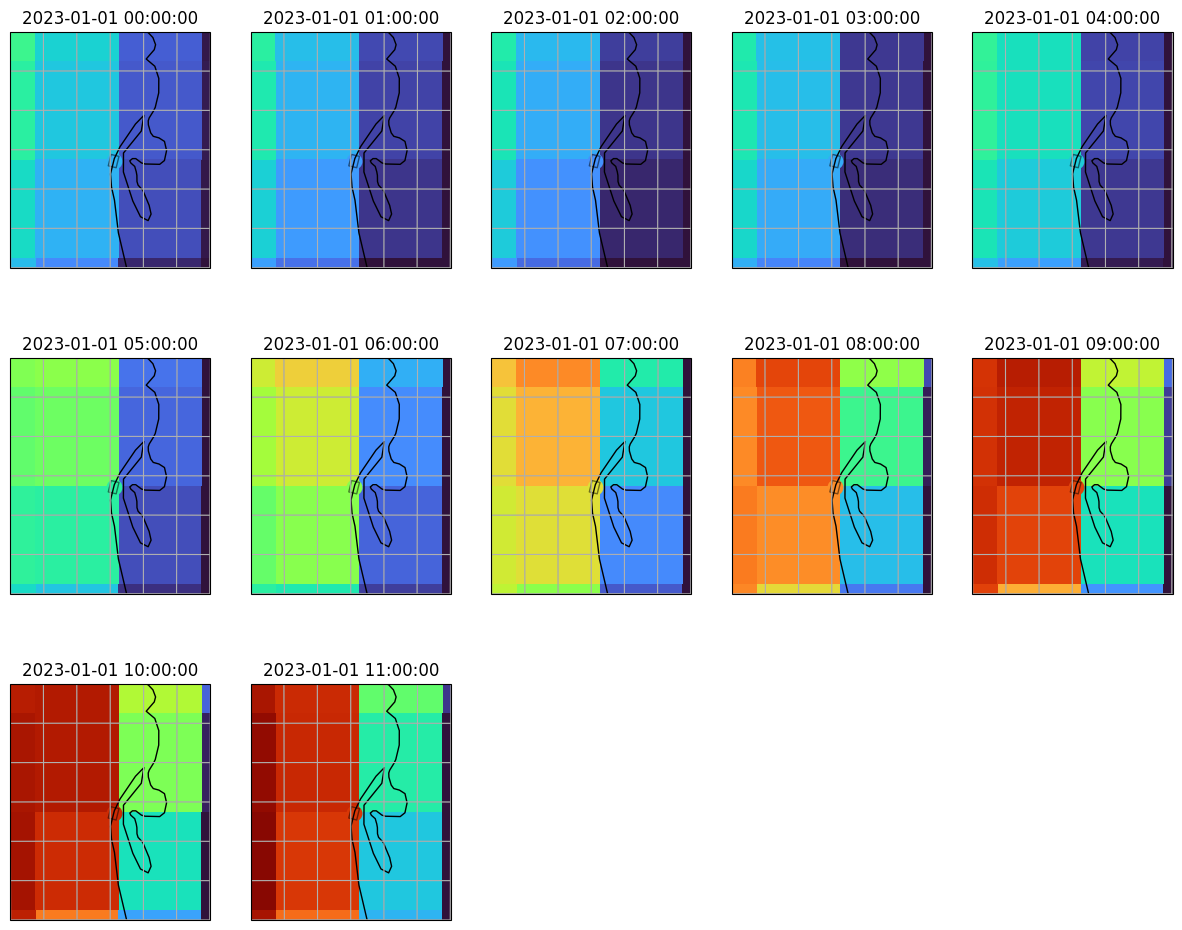

In [15]:
vmin = 4
vmax = 14
cmap = "turbo"

wspd = (dset.u10 ** 2 + dset.v10 ** 2) ** 0.5

fig, axs = plt.subplots(3, 5, figsize=(15, 12), subplot_kw=dict(projection=grid.projection))

for i, ax in enumerate(axs.flat):
    if i > 11:
        ax.axis("off")
        continue

    ax.coastlines()

    # Plot the source data
    source_data = wspd.isel(time=i)
    p = source_data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        add_colorbar=False,
    )

    # Plot the generated data
    generated_data = df.loc[df.index[i]]
    ax.scatter(
        grid.centre[0],
        grid.centre[1],
        s=110,
        c=generated_data.wspd,
        transform=grid.transform,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Plot the grid
    ax = grid.plot(
        ax=ax,
        grid_kwargs=dict(facecolor="none", edgecolor="black", alpha=0.5),
        set_gridlines=False,
        show_origin=False,
        show_offshore=False,
    )

    ax.set_extent([115.3, 115.9, -32.9, -32.3])
    ax.set_title(f"{generated_data.name}")
    ax.gridlines(draw_labels=False)

### Wind Point

Single-point timeseries data can also be used to prescribe forcing data. No spatial
selection is performed in this case, i.e., the data is assumed to be defined at the
appropriate location

Two point-based sources are currently available to allow prescribing data either
from a CSV file or from an existing pandas DataFrame object.

In [16]:
# Create the output directory
destdir = generate_output_directory()

# The WindGrid object should be used if the source data is a gridded dataset
wind = WindPoint(
    source=source_wind_timeseries,
    wind_vars=WindScalar(spd="wspd", dir="wdir"),
    # wind_vars=WindVector(u="u10", v="v10"),
)

namelist = wind.get(destdir=destdir, grid=grid, time=times)

windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       7.24     149.87
   3600.00       7.15     150.90
   7200.00       7.11     154.32
  10800.00       7.27     159.03
  14400.00       7.54     163.52
  18000.00       7.97     167.57
  21600.00       8.36     170.24
  25200.00       8.77     172.81
  28800.00       9.17     174.48
  32400.00       9.54     174.92
  36000.00       9.78     177.59
  39600.00      10.09     175.46
  43200.00      10.19     172.35



In [17]:
# Generated wind data
df = pd.read_csv(windfile, header=None, sep="\s+", names=["tsec", "wspd", "wdir"])
df.index = [times.start + timedelta(seconds=s) for s in df.tsec]
display(df)

# Source dataset
df0 = pd.read_csv(source_wind_timeseries.filename, parse_dates=["time"], index_col="time")
display(df0)

,tsec,wspd,wdir
2023-01-01 00:00:00,0.0,7.24,149.87
2023-01-01 01:00:00,3600.0,7.15,150.90
2023-01-01 02:00:00,7200.0,7.11,154.32
2023-01-01 03:00:00,10800.0,7.27,159.03
2023-01-01 04:00:00,14400.0,7.54,163.52
2023-01-01 05:00:00,18000.0,7.97,167.57
2023-01-01 06:00:00,21600.0,8.36,170.24
2023-01-01 07:00:00,25200.0,8.77,172.81
2023-01-01 08:00:00,28800.0,9.17,174.48
2023-01-01 09:00:00,32400.0,9.54,174.92


,u10,v10,wspd,wdir
time,,,,
2023-01-01 00:00:00,-3.633700,6.260819,7.238897,149.86966
2023-01-01 01:00:00,-3.476098,6.245619,7.147798,150.90118
2023-01-01 02:00:00,-3.082727,6.410751,7.113433,154.31857
2023-01-01 03:00:00,-2.603631,6.792392,7.274303,159.02739
2023-01-01 04:00:00,-2.139115,7.232939,7.542627,163.52463
2023-01-01 05:00:00,-1.715853,7.784421,7.971284,167.56956
2023-01-01 06:00:00,-1.418075,8.242932,8.364022,170.23866
2023-01-01 07:00:00,-1.097202,8.703077,8.771967,172.81460
2023-01-01 08:00:00,-0.881369,9.128032,9.170484,174.48483


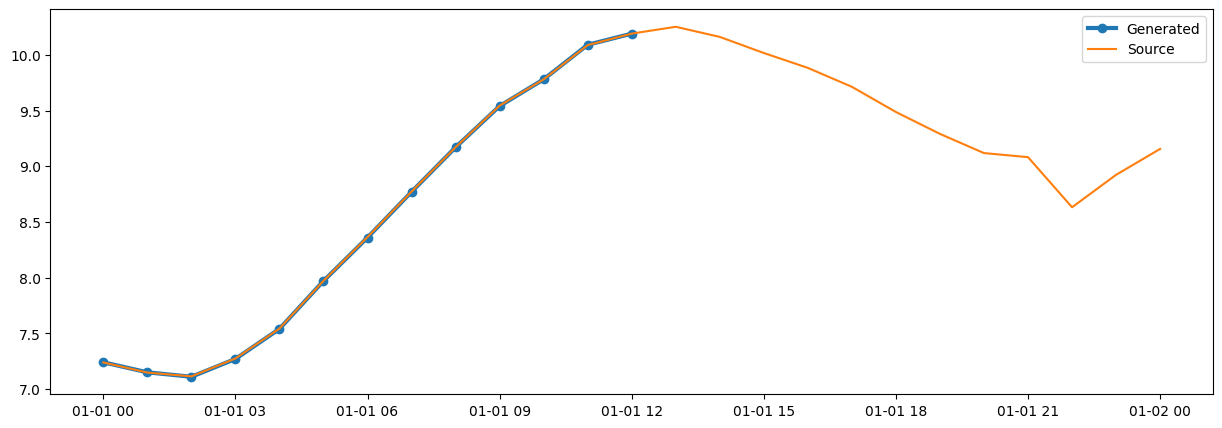

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df.index, df.wspd, "o-", linewidth=3, label="Generated")
ax.plot(df0.index, df0.wspd, label="Source")
l = ax.legend()

## Tide forcing

The Tide data object can be used to generate tide elevation data from constituents.
The object takes an oceantide source which opens an xarray dataset with the oceantide
accessor and generates tide elevation timeseries to define the `zs0file`.

### Tide cons grid

Generate tide timeseries by selecting from gridded constituent data

In [19]:
from rompy_xbeach.source import SourceCRSOceantide
from rompy_xbeach.forcing import TideConsGrid

In [20]:
# Create the output directory
destdir = generate_output_directory()

# The source must return a dataset with the oceantide accessor
source = SourceCRSOceantide(
    reader="read_otis_binary",
    kwargs=dict(
        gfile="../../../rompy-xbeach/tests/data/swaus_tide_cons/grid_m2s2n2k2k1o1p1q1mmmf",
        hfile="../../../rompy-xbeach/tests/data/swaus_tide_cons/h_m2s2n2k2k1o1p1q1mmmf",
        ufile="../../../rompy-xbeach/tests/data/swaus_tide_cons/u_m2s2n2k2k1o1p1q1mmmf",
    ),
    crs=4326,
    x_dim="lon",
    y_dim="lat",
)

# The TideGrid object should be used if the source data is a gridded constituents dataset
tide = TideConsGrid(
    source=source,
    coords=dict(x="lon", y="lat"),
)

namelist = tide.get(destdir=destdir, grid=grid, time=times)
print(namelist)

tidefile = destdir / namelist["zs0file"]
print(tidefile.read_text())

{'zs0file': 'tide-20230101T000000-20230101T120000.txt', 'tideloc': 1, 'tidelen': 13}
      0.00      -0.12
   3600.00      -0.10
   7200.00      -0.07
  10800.00      -0.04
  14400.00       0.00
  18000.00       0.05
  21600.00       0.09
  25200.00       0.14
  28800.00       0.17
  32400.00       0.20
  36000.00       0.21
  39600.00       0.21
  43200.00       0.19



Plot the generated data

In [21]:
# Load the generated tide data
df = pd.read_csv(tidefile, header=None, sep="\s+", names=["tsec", "zs"])
df.index = [times.start + timedelta(seconds=s) for s in df.tsec]
display(df)

,tsec,zs
2023-01-01 00:00:00,0.0,-0.12
2023-01-01 01:00:00,3600.0,-0.10
2023-01-01 02:00:00,7200.0,-0.07
2023-01-01 03:00:00,10800.0,-0.04
2023-01-01 04:00:00,14400.0,0.00
2023-01-01 05:00:00,18000.0,0.05
2023-01-01 06:00:00,21600.0,0.09
2023-01-01 07:00:00,25200.0,0.14
2023-01-01 08:00:00,28800.0,0.17
2023-01-01 09:00:00,32400.0,0.20


<Axes: >

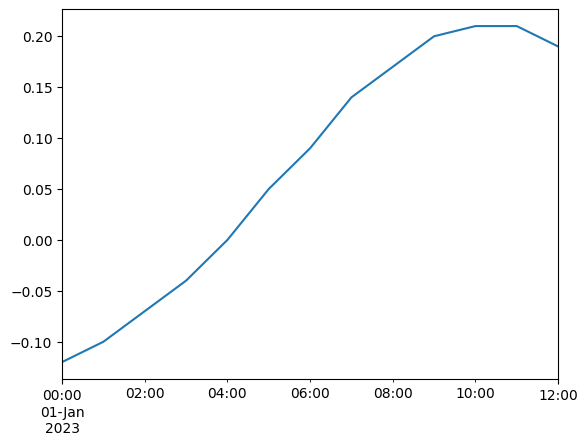

In [22]:
df.zs.plot()

### Tide cons point

Generate tide timeseries from constituent table for single point location

In [23]:
from rompy_xbeach.source import SourceTideConsPointCSV
from rompy_xbeach.forcing import TideConsPoint

In [24]:
# Create the output directory
destdir = generate_output_directory()

# The source must return a dataset with the oceantide accessor
source = SourceTideConsPointCSV(
    filename="../../../rompy-xbeach/tests/data/tide_cons_station.csv",
    acol="amplitude",
    pcol="phase",
    ccol="constituent",
)

# The TidePoint object should be used if the source data is a point constituents dataset
tide = TideConsPoint(source=source)

namelist = tide.get(destdir=destdir, grid=grid, time=times)
print(namelist)

tidefile = destdir / namelist["zs0file"]
print(tidefile.read_text())

{'zs0file': 'tide-20230101T000000-20230101T120000.txt', 'tideloc': 1, 'tidelen': 13}
      0.00      -0.20
   3600.00      -0.15
   7200.00      -0.09
  10800.00      -0.02
  14400.00       0.06
  18000.00       0.13
  21600.00       0.19
  25200.00       0.24
  28800.00       0.26
  32400.00       0.26
  36000.00       0.23
  39600.00       0.20
  43200.00       0.15



Plot the generated data

In [25]:
# Load the generated tide data
df = pd.read_csv(tidefile, header=None, sep="\s+", names=["tsec", "zs"])
df.index = [times.start + timedelta(seconds=s) for s in df.tsec]
display(df)

,tsec,zs
2023-01-01 00:00:00,0.0,-0.20
2023-01-01 01:00:00,3600.0,-0.15
2023-01-01 02:00:00,7200.0,-0.09
2023-01-01 03:00:00,10800.0,-0.02
2023-01-01 04:00:00,14400.0,0.06
2023-01-01 05:00:00,18000.0,0.13
2023-01-01 06:00:00,21600.0,0.19
2023-01-01 07:00:00,25200.0,0.24
2023-01-01 08:00:00,28800.0,0.26
2023-01-01 09:00:00,32400.0,0.26


<Axes: >

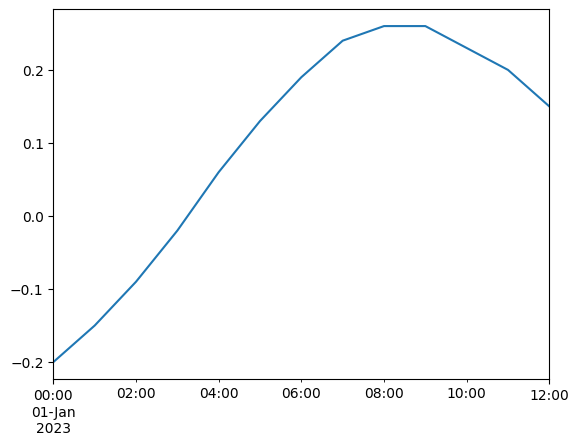

In [26]:
df.zs.plot()